In [616]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import show_image
from scipy.sparse import csc_matrix, find
from PIL import Image
import random
from scipy.spatial.distance import cdist
import copy
import time

## Load Images

In [617]:
#Sources
#1 ED discussion #168
#2 https://stackoverflow.com/questions/25102461/python-rgb-matrix-of-an-image
image1 = 'football.bmp'
image2 = 'hestain.bmp'
image3 = 'AC_DC.png'
im = Image.open(image1)

#arr = np.array(im)



#confirm max value is no greather than 255
#np.max(arr)

## Initialize Clusters + Set Initial Parameters

In [618]:
#set k
#k=6

In [619]:
#k_clusters = [2,4,8,16]
#init_c = np.random.randint(0,255,size=(k,3))

#print clusters
#print(init_c)

## Reshape Array

In [620]:
#preserve original dimensions for reshaping back
#w,h,rgb = np.shape(arr)
#np.shape(arr)

In [621]:
#Expand into one long 2d array. Use -1 to infer correct dimension
#arr_reshaped = np.reshape(arr,(-1, 3))

In [622]:
#We have 255440 412x620 elements with 3 columns
#arr_reshaped.shape

In [623]:
#dim = np.shape(arr_reshaped)[1]

In [624]:
def reshape_array(image):
    im = Image.open(image)
    arr = np.array(im)
    #preserve original dimensions for reshaping back
    w,h,rgb = np.shape(arr)
    
    #Expand into one long 2d array. Use -1 to infer correct dimension
    array_reshaped = np.reshape(arr,(-1, 3))
    dim = np.shape(array_reshaped)[1]
    return array_reshaped,w,h,rgb,dim

## Calculate Distance

In [625]:
def calc_distance(array,centroids,distance_measure):
    distance_vals = cdist(array, centroids, distance_measure)
    return distance_vals

In [626]:
# Test
#calc_distance(arr_reshaped,init_c,"Euclidean")

In [627]:
#initialize centroids with zero values
#new_centroids = np.zeros((k,dim))

In [628]:
#use scipy cdist formula. Different Distances tested here
#Sources
# https://edstem.org/us/courses/25802/discussion/1698905
# https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
#distance_vals = cdist(arr_reshaped, init_c, "Euclidean")
#distance_vals

## Assign to Clusters

In [629]:
def assigntoclusters(distance_vals):
    cluster_assign = np.nanargmin(distance_vals,axis=1)
    
    #Determine if a cluster has zero assignments
    cl_counts = np.unique(cluster_assign, return_counts=True)
    
    #create array of cluster indices
    k_array = np.array([i for i in range(0,k)])
    
    #test for cluster indices in cluster assignment counts
    test = np.isin(k_array,cl_counts[0])
    if np.sum(test) == k:
        zero_idx = None
    else:
        zero_idx = np.where(test == 0)[0][0]
        
    return cluster_assign, zero_idx

In [630]:
#distance_vals.min(axis=1)
#np.where(distance_vals == distance_vals.min())
#cluster_assign = np.nanargmin(distance_vals, axis=1)
#cluster_assign

In [631]:
#Determine if a cluster has zero assignments
#cl_counts = np.unique(cluster_assign, return_counts=True)
#cl_counts

In [632]:
#create array of cluster indices
#k_array = np.array([i for i in range(0,k)])
#k_array

In [633]:
#test for cluster indices in cluster assignment counts
#test = np.isin(k_array,cl_counts[0])
#if np.sum(test) == k:
#    zero_idx = np.empty(1)
#else:
#    zero_idx = np.where(test == 0)[0][0]

In [634]:
#np.empty(1)

In [635]:
#create zero_idx
#print(zero_idx)
#print(np.sum(test))
#print(init_c)

In [636]:
#Find its index and save for later
#zero_idx = None
#if np.min(cl_counts[1]) == 0:
    #idx = np.where(cl_counts[1] == 0)
    #zero_idx = idx[0][0]

## Recalculate Centroids

In [637]:
# loop through clusters and recalculate centroids
def calculate_centroids(k,zero_idx,new_centroids,cluster_assignments,current_iteration,array):
    for i in range(0,k):
        #print(i)
        idx = np.where(cluster_assignments==i)
        ##idx = find(P[:, k])[0]
        #idx = find(cluster_assign[:])[0]
        #print("was not zero_idx")
        new_centroids[i] = np.nanmean(array[idx],axis=0) #calculate mean for new centroid
        #print(np.mean(arr_reshaped[idx],axis=0))
        #print(new_centroids[i])
    return new_centroids

In [638]:
#test
#calculate_centroids(k,zero_idx,new_centroids,cluster_assign)

## Loop

In [639]:
def run_kMeans(array,k,initial_centroids,max_iters,distance_measure,dim):
    #source Demo Code - Kmeans_animation.py
    prev_centroids = initial_centroids
    #print(initial_centroids)
    max_iterations = max_iters
    current_iteration = 0
    
    #initialize centroids with zero values
    new_centroids = np.zeros((k,dim))
                             
    #Main Algorithm                         
    while np.linalg.norm(new_centroids-prev_centroids, ord = 'fro') > 1e-6 and current_iteration < max_iterations: #source demo code

        if current_iteration == 0:
            #calculate distances
            distances = calc_distance(array,prev_centroids,distance_measure)
            #assign to clusters
            cluster_assignments,zeros = assigntoclusters(distances)
            #print(cluster_assignments,zeros)
            #calculate new centroids
            new_centroids = calculate_centroids(k,zeros,new_centroids,cluster_assignments,current_iteration,array)
        else:
            prev_centroids = copy.deepcopy(new_centroids) #source demo code kmeans animation
            #calculate distances
            distances = calc_distance(array,prev_centroids,distance_measure)
            #assign to clusters
            cluster_assignments,zeros = assigntoclusters(distances)
            #calculate new centroids
            new_centroids = calculate_centroids(k,zeros,new_centroids,cluster_assignments,current_iteration,array)
            #print(np.linalg.norm(new_centroids-prev_centroids, ord = 'fro'))

        current_iteration = current_iteration+1
        #print(new_centroids)
        reduced_k = np.sum(np.isnan(new_centroids))
        #print(reduced_k)
        k=int(k-reduced_k/3)
        #print(k)
           
        prev_centroids = prev_centroids[~np.isnan(new_centroids).all(axis=1),:]
        new_centroids = new_centroids[~np.isnan(new_centroids).all(axis=1),:]
        #print(current_iteration)
        #print(new_centroids)
        #print(prev_centroids)
        #print(np.linalg.norm(new_centroids-prev_centroids, ord = 'fro'))
    print("Finished in {} iterations".format(current_iteration))
    #print(new_centroids)
    return new_centroids

In [640]:
#run_kMeans(arr_reshaped,k,init_c,300,"Euclidean")

In [641]:
#print(new_centroids)

In [642]:
# #source Demo Code - Kmeans_animation.py
# prev_centroids = init_c
# max_iterations = 300
# current_iteration = 0

# #initialize centroids with zero values
# new_centroids = np.zeros((k,dim))

# while np.linalg.norm(new_centroids-prev_centroids, ord = 'fro') > 1e-6 and current_iteration < max_iterations: #source demo code
    
#     if current_iteration == 0:
#         #calculate distances
#         distances = calc_distance(arr_reshaped,prev_centroids,"Euclidean")
#         #assign to clusters
#         cluster_assignments = assigntoclusters(distances)
#         #calculate new centroids
#         new_centroids = calculate_centroids(k,zero_idx,new_centroids,cluster_assignments,current_iteration)
#     else:
#         prev_centroids = copy.deepcopy(new_centroids) #source demo code kmeans animation
#         #calculate distances
#         distances = calc_distance(arr_reshaped,prev_centroids,"Euclidean")
#         #assign to clusters
#         cluster_assignments = assigntoclusters(distances)
#         #calculate new centroids
#         new_centroids = calculate_centroids(k,zero_idx,new_centroids,cluster_assignments,current_iteration)
    
#     current_iteration = current_iteration+1
#     #print(current_iteration)
#     #print(new_centroids)
#     #print(prev_centroids)
#     #print(np.linalg.norm(new_centroids-prev_centroids, ord = 'fro'))
# print("Finished in {} iterations".format(current_iteration))

## Assign Data Points to Final Clusters

In [643]:
def final_assignment(input_array,centroids,distance_measure,w,h,rgb):
    #Calc distances
    final_distances =  calc_distance(input_array,centroids,distance_measure)
    
    #assign to final clusters
    final_assignments,zeros = assigntoclusters(final_distances)
    
    #assign new pixel values to original data
    final_arr = input_array
    for c,i in enumerate(final_assignments):
        final_arr[c] = new_centroids[i]
    #print(final_arr) 
    #reshape to original dimensions)
    final_image = np.reshape(final_arr,(w,h,rgb))
    
    #create final image
    final_image = Image.fromarray(final_image) #source https://www.geeksforgeeks.org/convert-a-numpy-array-to-an-image/
    
    return final_image

In [644]:
#final_assignment(arr_reshaped,new_centroids,"Euclidean")

# Euclidean k-means

## Image 1

Finished in 68 iterations
--- 2.1949639320373535 seconds ---


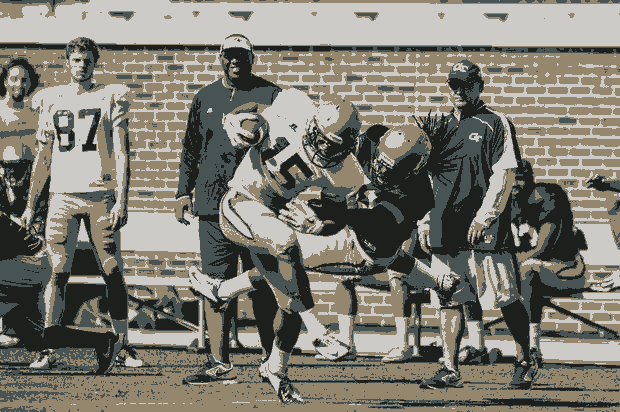

In [645]:
k=4
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image1)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time)) #source https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 35 iterations
--- 1.4059960842132568 seconds ---


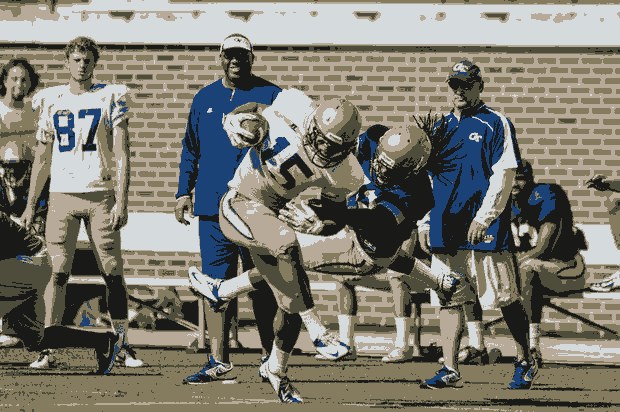

In [646]:
k=6
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image1)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time)) #source https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 63 iterations
--- 2.9150354862213135 seconds ---


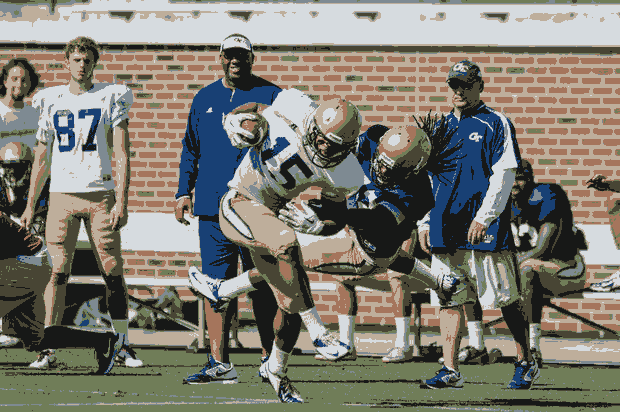

In [647]:
k=8
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image1)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time)) #source https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 104 iterations
--- 6.75006890296936 seconds ---


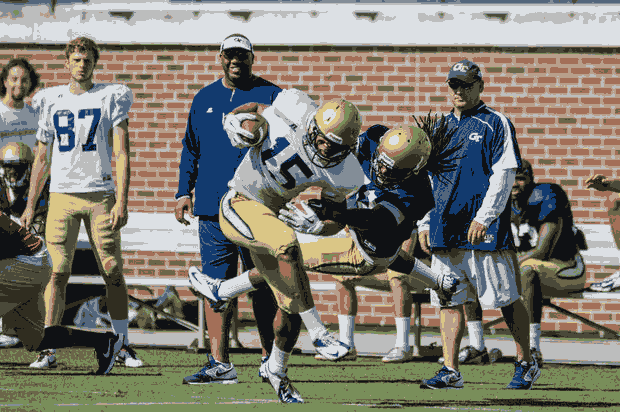

In [648]:
k=16
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image1)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time)) #source https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 46 iterations
--- 3.6590044498443604 seconds ---


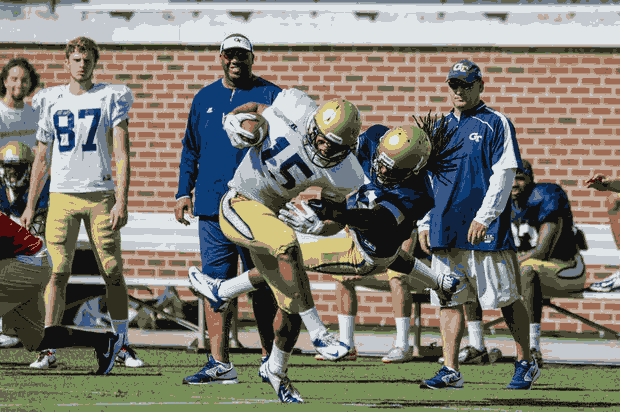

In [649]:
k=24
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image1)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time)) #source https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

## Image 2

Finished in 70 iterations
--- 0.5999984741210938 seconds ---


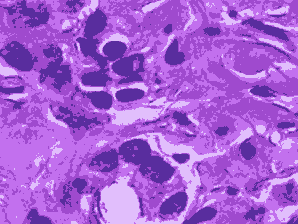

In [650]:
k=4
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image2)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 43 iterations
--- 0.3369944095611572 seconds ---


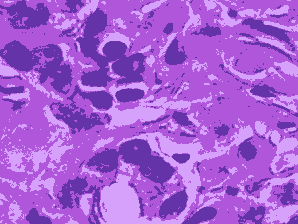

In [651]:
k=6
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image2)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 53 iterations
--- 0.5290374755859375 seconds ---


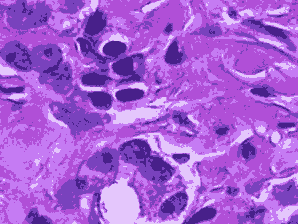

In [652]:
k=8
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image2)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 60 iterations
--- 0.7610106468200684 seconds ---


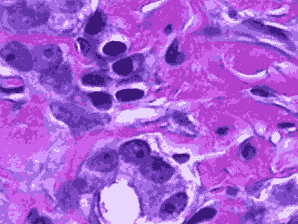

In [653]:
k=16
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image2)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 82 iterations
--- 1.1630234718322754 seconds ---


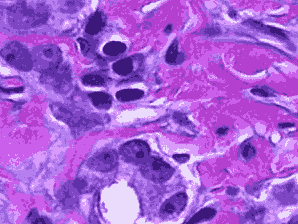

In [654]:
k=24
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image2)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

## Image 3

Finished in 47 iterations
--- 5.340031385421753 seconds ---


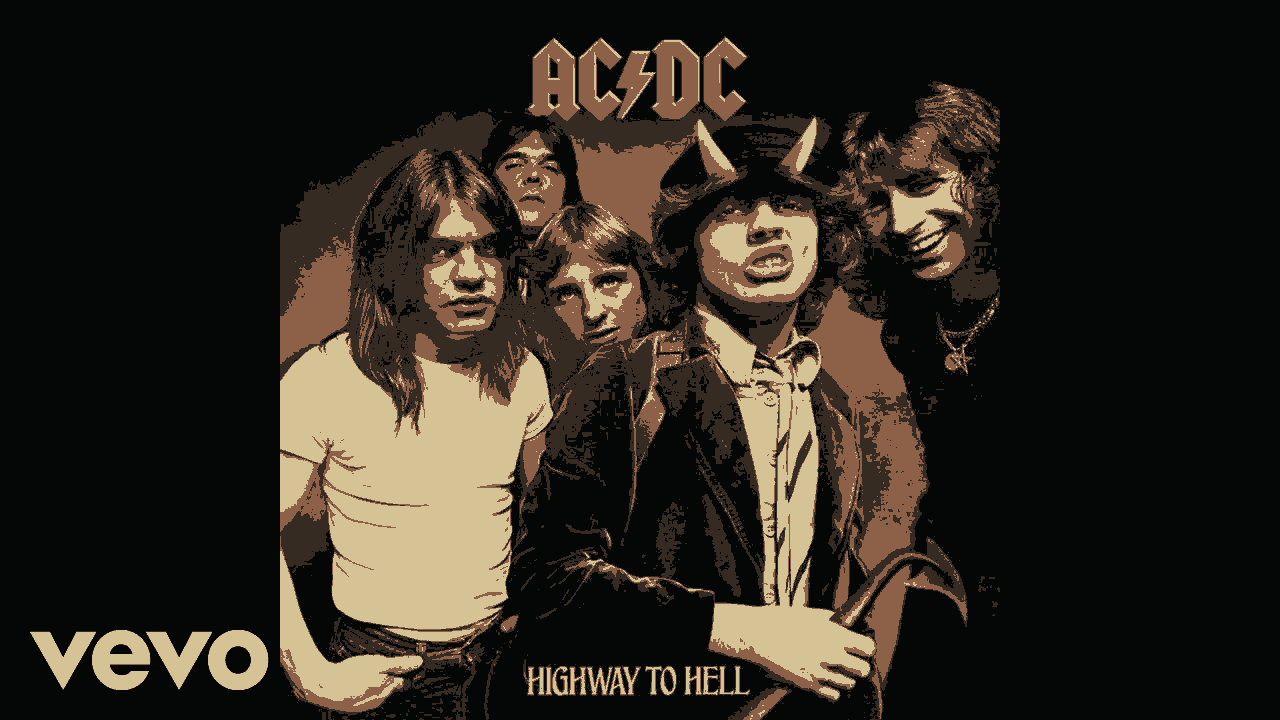

In [655]:
k=4
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image3)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 39 iterations
--- 4.875032424926758 seconds ---


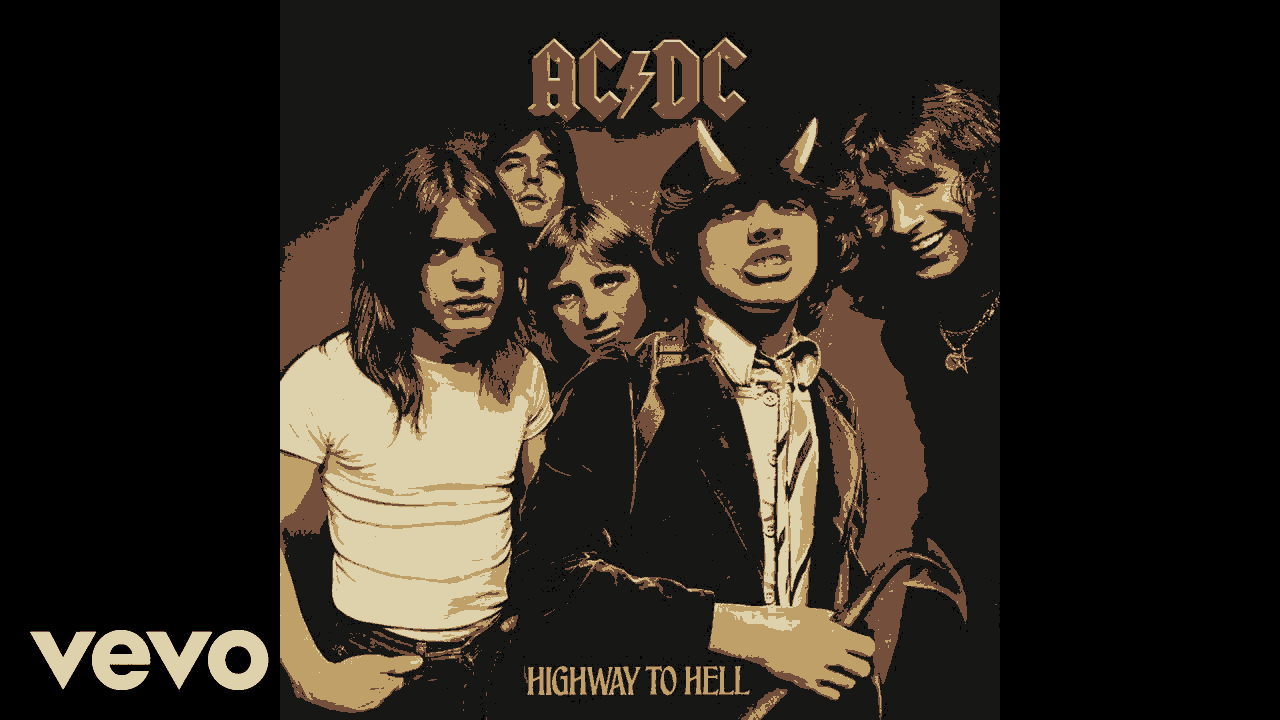

In [656]:
k=6
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image3)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 66 iterations
--- 9.34706735610962 seconds ---


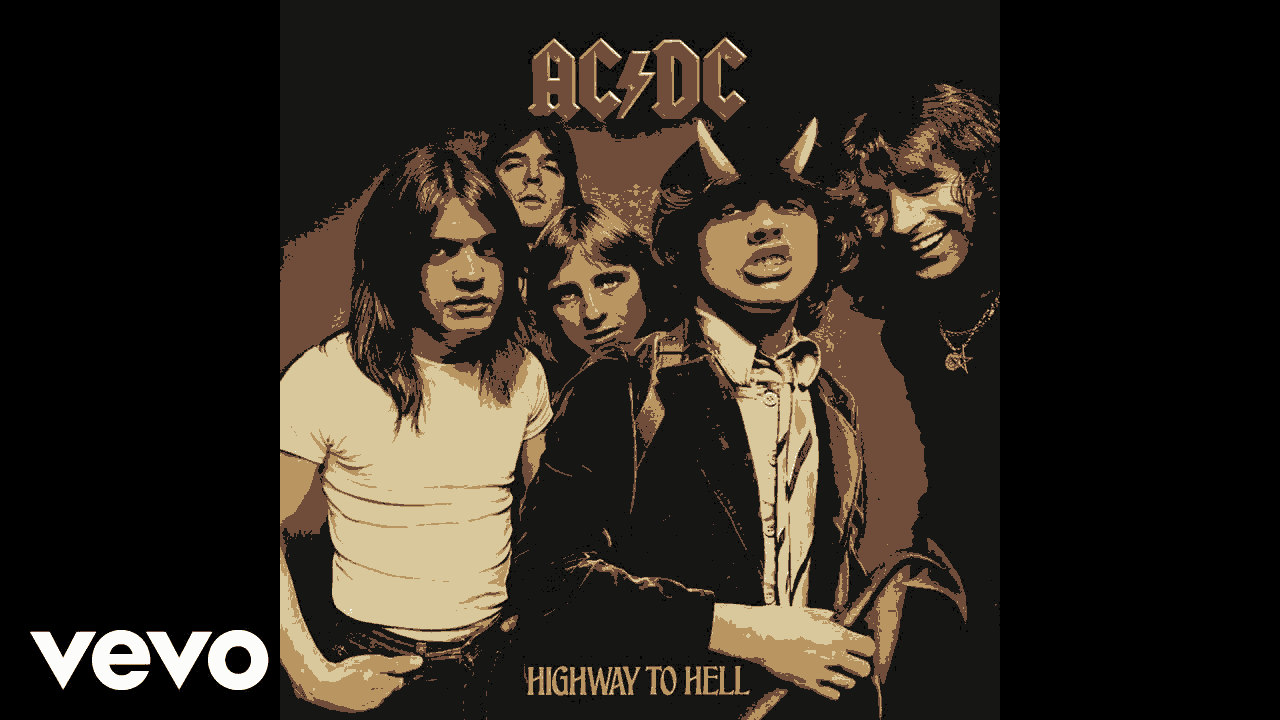

In [657]:
k=8
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image3)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 246 iterations
--- 57.49207043647766 seconds ---


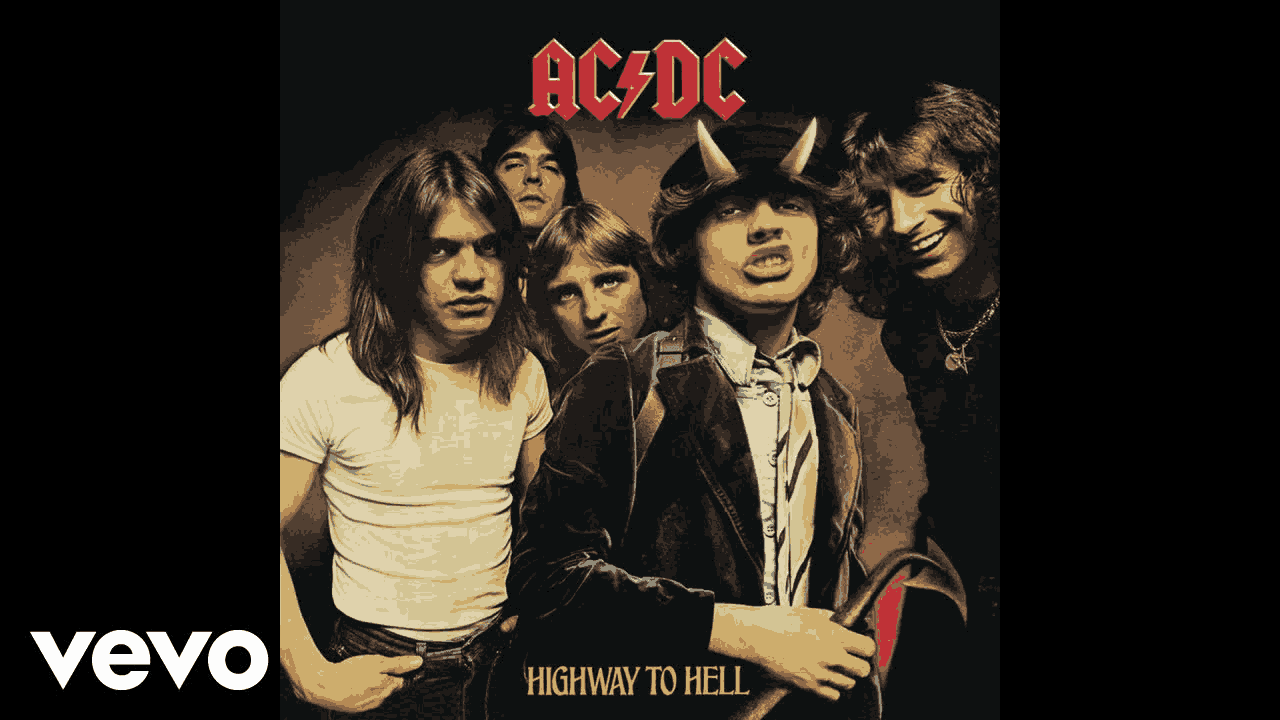

In [658]:
k=16
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image3)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

Finished in 262 iterations
--- 61.993995666503906 seconds ---


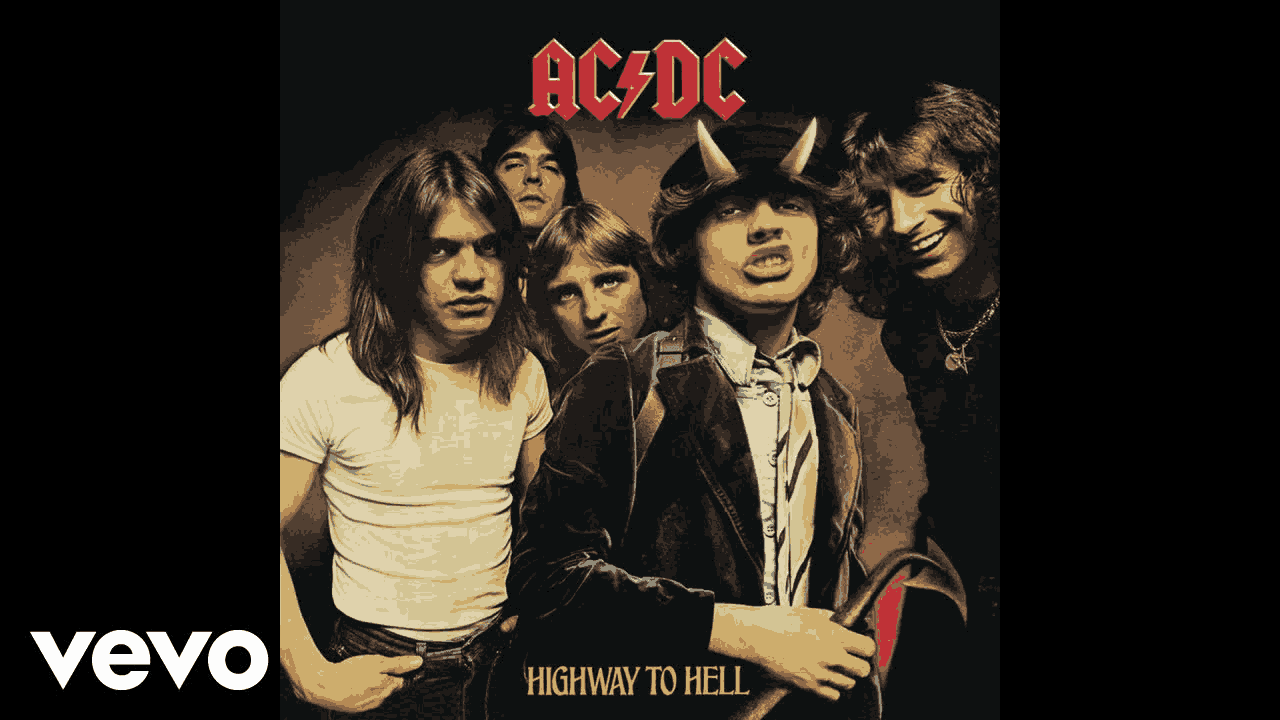

In [659]:
k=24
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image3)
new_centroids = run_kMeans(array1,k,init_c,300,"Euclidean",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"Euclidean",w,h,rgb)

## Manhattan Distance k-Means

## Image 1 Manhattan Distance

Finished in 43 iterations
--- 1.2309668064117432 seconds ---


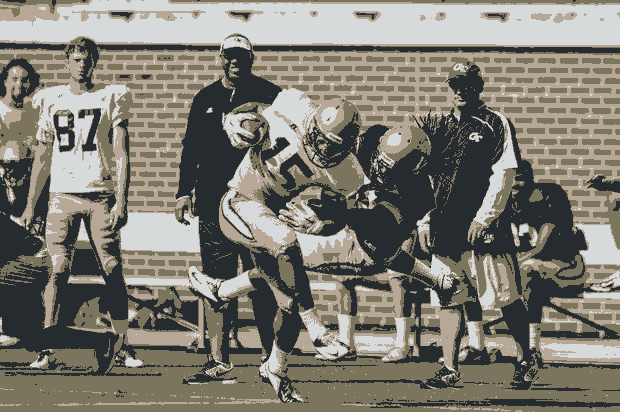

In [660]:
k=4
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image1)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 21 iterations
--- 0.7100133895874023 seconds ---


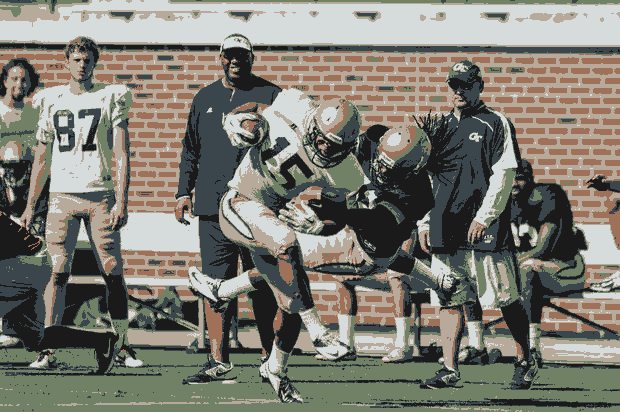

In [661]:
k=6
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image1)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 52 iterations
--- 2.0470099449157715 seconds ---


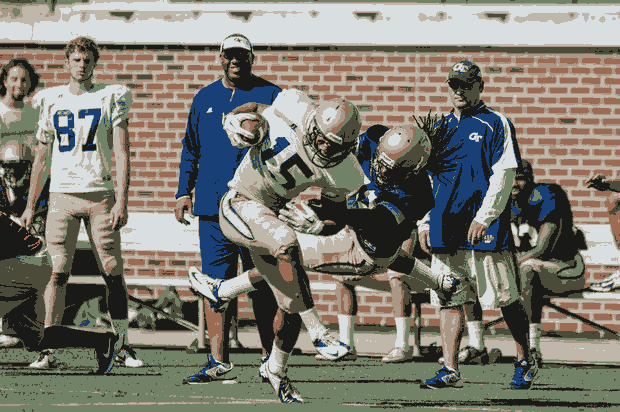

In [662]:
k=8
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image1)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 78 iterations
--- 4.390996694564819 seconds ---


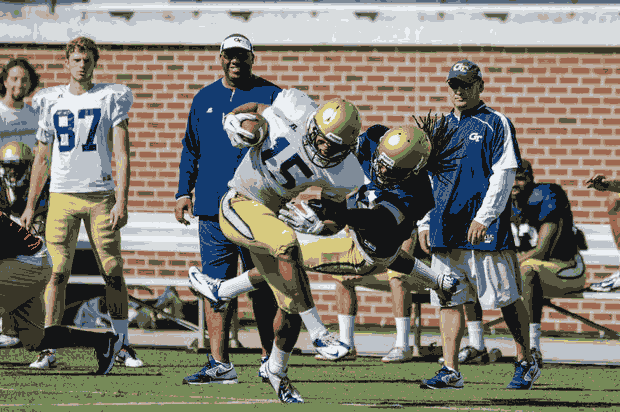

In [663]:
k=16
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image1)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 59 iterations
--- 3.696007490158081 seconds ---


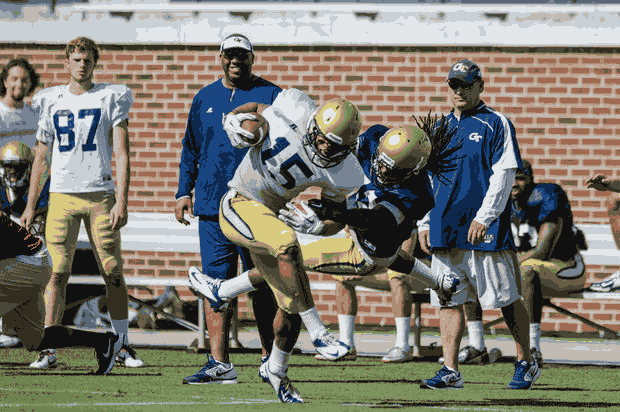

In [664]:
k=24
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image1)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

## Image 2 Manhattan Distance

Finished in 42 iterations
--- 0.3240361213684082 seconds ---


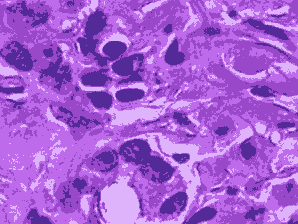

In [665]:
k=4
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image2)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 21 iterations
--- 0.17296361923217773 seconds ---


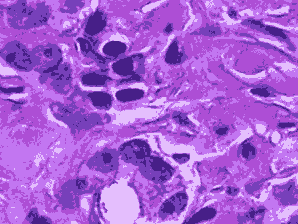

In [666]:
k=6
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image2)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 28 iterations
--- 0.24604463577270508 seconds ---


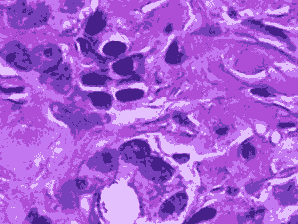

In [667]:
k=8
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image2)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 39 iterations
--- 0.4240071773529053 seconds ---


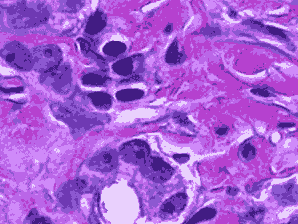

In [668]:
k=16
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image2)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 85 iterations
--- 1.1569933891296387 seconds ---


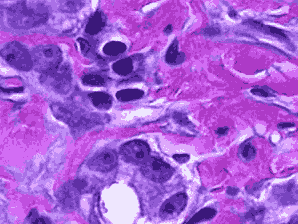

In [669]:
k=24
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image2)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

## Image 3 Manhattan Distance

Finished in 33 iterations
--- 3.394968271255493 seconds ---


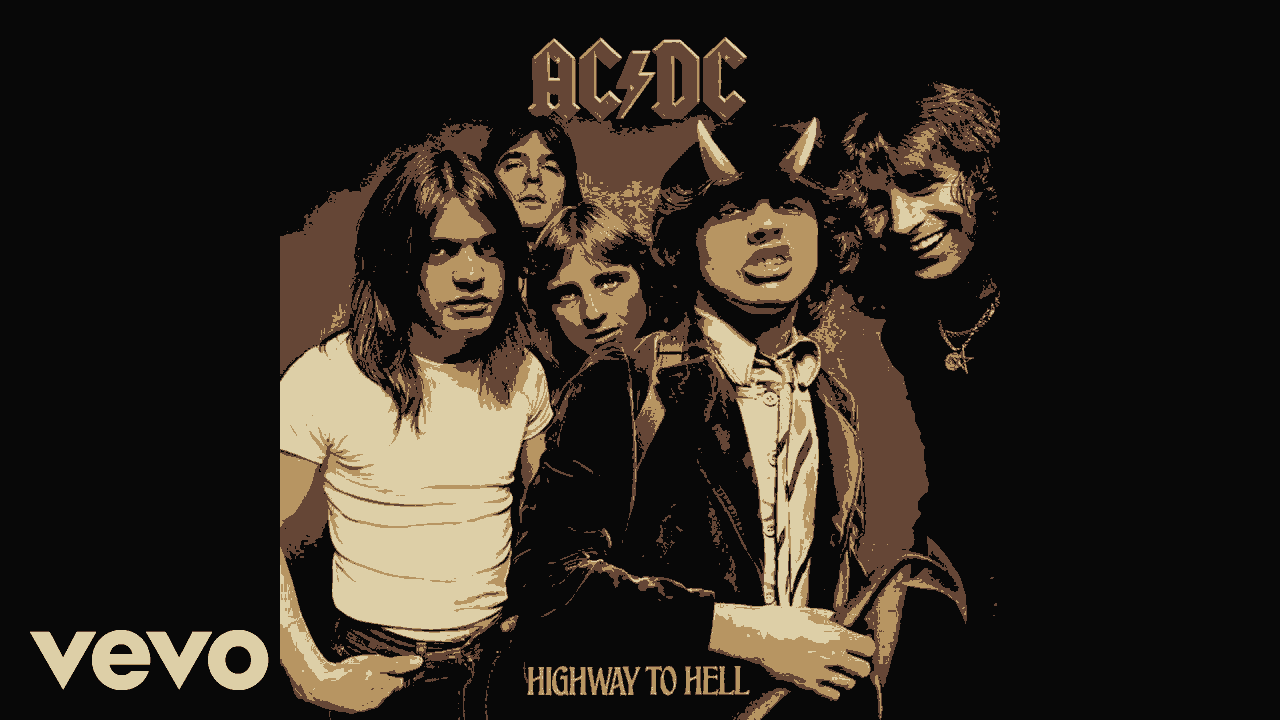

In [670]:
k=4
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image3)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 67 iterations
--- 7.175040245056152 seconds ---


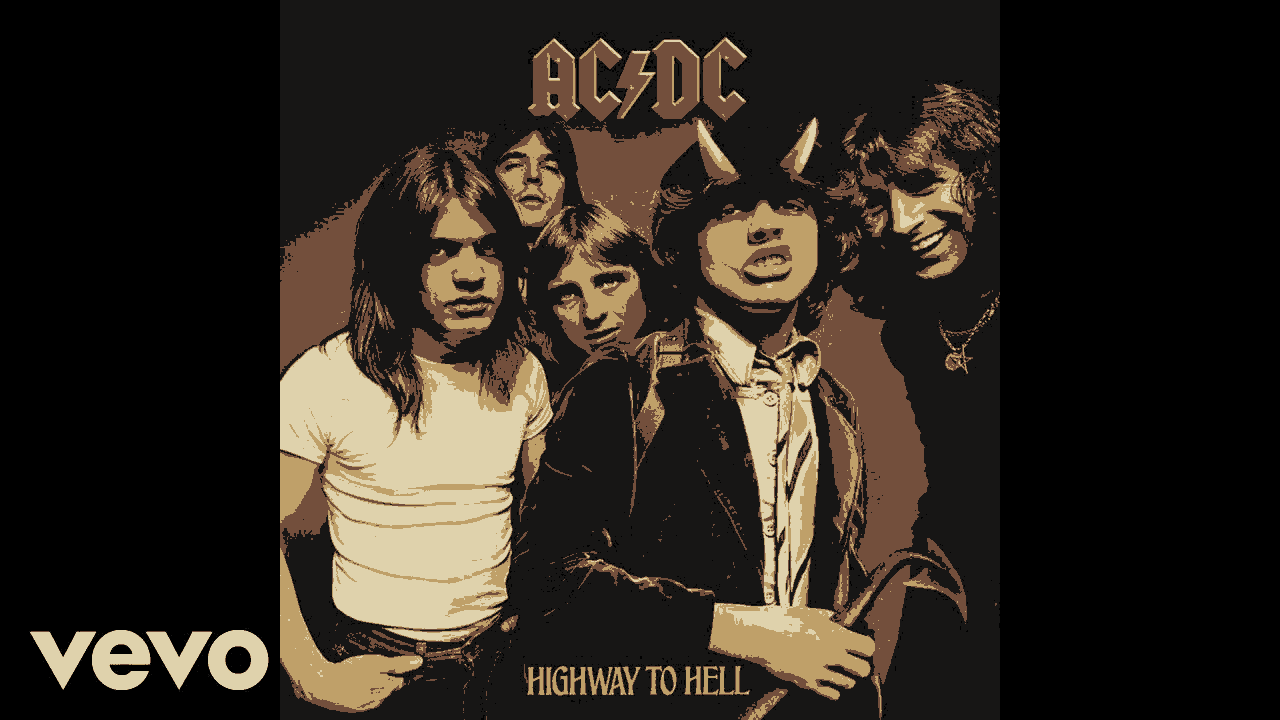

In [671]:
k=6
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image3)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 52 iterations
--- 6.440004348754883 seconds ---


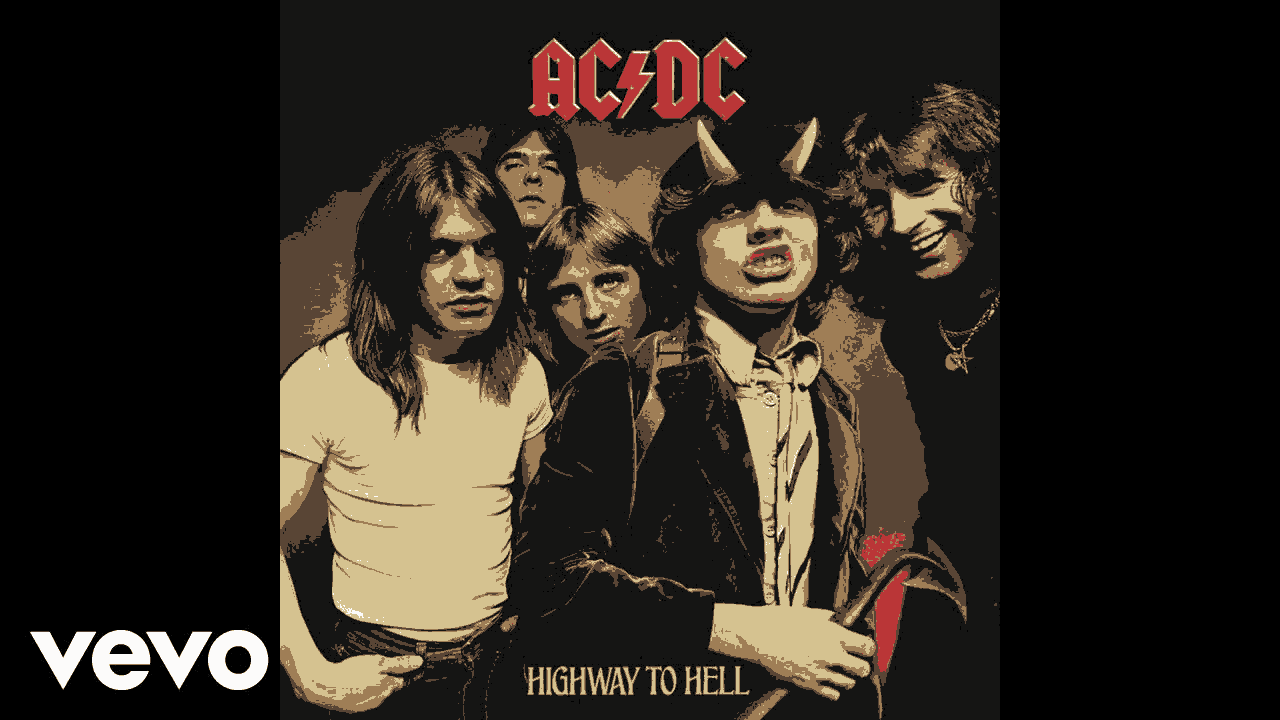

In [672]:
k=8
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image3)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 49 iterations
--- 7.973042249679565 seconds ---


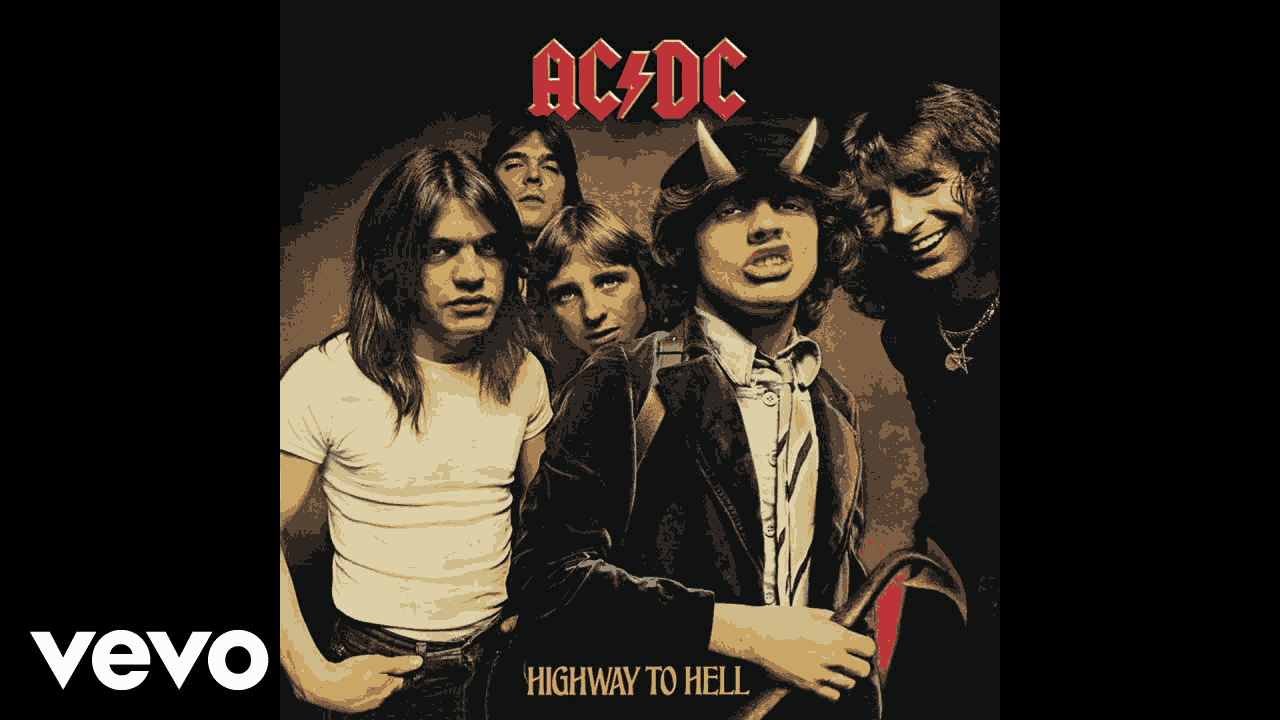

In [673]:
k=16
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image3)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 48 iterations
--- 10.330017566680908 seconds ---


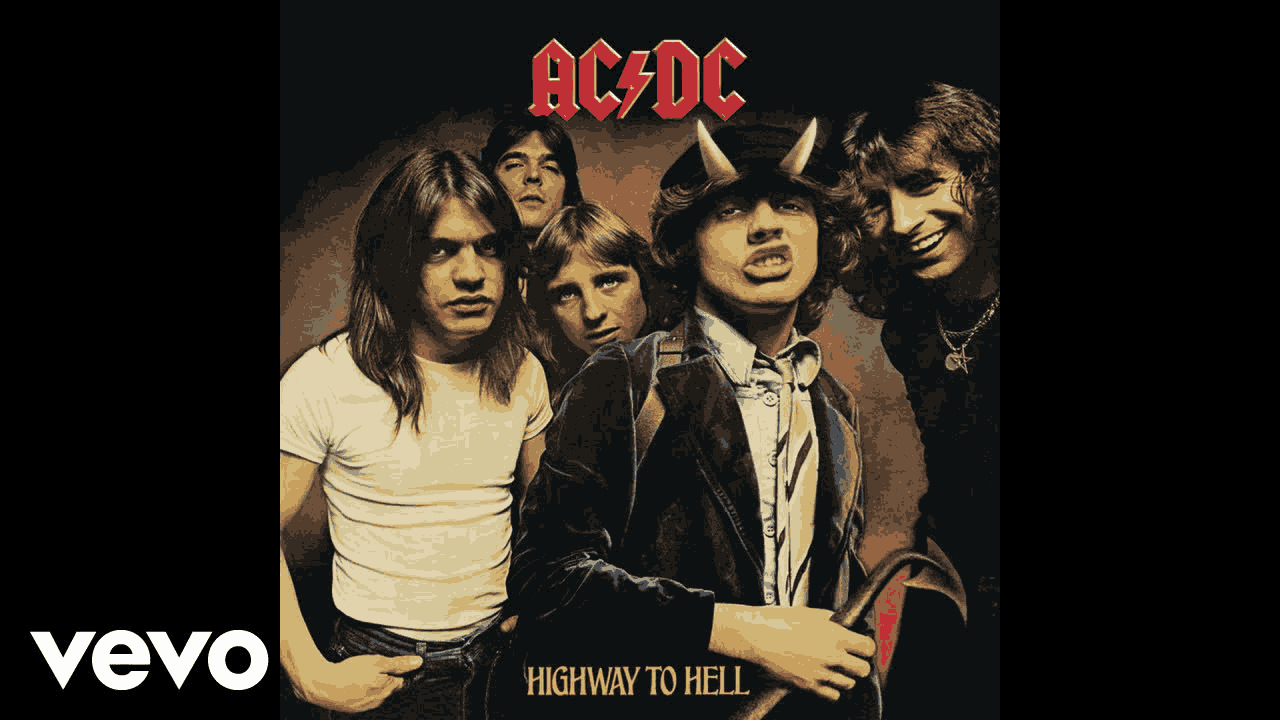

In [674]:
k=24
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image3)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)

Finished in 153 iterations
--- 50.17286729812622 seconds ---


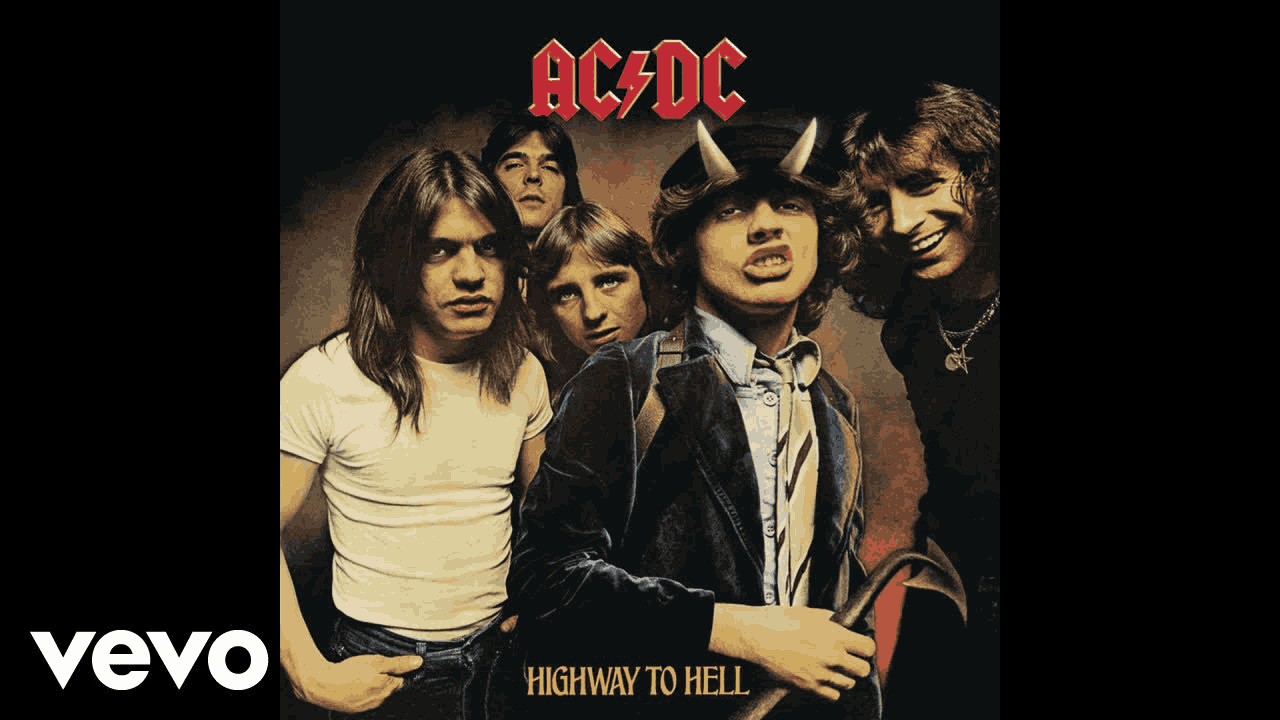

In [675]:
k=64
start_time = time.time()
init_c = np.random.randint(0,255,size=(k,3))
array1,w,h,rgb,dim = reshape_array(image3)
new_centroids = run_kMeans(array1,k,init_c,300,"cityblock",dim)
print("--- %s seconds ---" % (time.time() - start_time))
#print(new_centroids)
final_assignment(array1,new_centroids,"cityblock",w,h,rgb)